In [8]:
pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.5.1%2Bcu118-cp312-cp312-win_amd64.whl (4.0 MB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.5.1%2Bcu118-cp312-cp312-win_amd64.whl (2700.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
##installs pytorch on a cuda-capable windows machine using pip

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install torchsummary

!pip install numpy

!pip install matplotlib

!pip install opencv-python

!pip install scikit-learn

!pip install pandas

!pip install pickle5

SyntaxError: invalid syntax (3373289064.py, line 3)

In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [ ]:
from torch.utils.data import Dataset
from enum import Enum

class datasets(Enum):
    TRAINING_LABELED = ["train_small.csv", "train_set"]
    TRAINING_UNLABELED = ["train_unlabeled.csv", "train_set"]
    TEST = ["val_info.csv", "val_set"]
    TEST_DEGRADED = ["val_info.csv", "val_set_degraded"]

class networks(Enum):
    ALEXNET = [277, models.alexnet(pretrained=True), "AlexNet"]
    RESNET50 = [224, models.resnet50(pretrained=True), "ResNet50"]
    GOOGLENET = [224, models.googlenet(pretrained=True), "GoogLeNet"]

class ImageDataset(Dataset):
    def __init__(self, dataset, network_input_size):
        super().__init__()
        self.images_names = []
        self.labels = []
        dataset = dataset.value
        annotations_file = dataset[0]
        img_dir = dataset[1]
        with open(annotations_file, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                self.images_names.append("./{}/{}".format(img_dir, row[0]))
                self.labels.append(row[1])
        self.images_names = np.array(self.images_names)
        self.labels = np.array(self.labels)
        # in base al valore passato si sceglie la rete che utilizzerà il dataset, serve per modificare le dimensioni delle immagini
        self.im_size = network_input_size
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        #moveaxis serve per avere come dimensione dell'immagine (3, righe, colonne) invece di (righe, colonne, 3)
        image = np.moveaxis(cv2.resize((cv2.imread(self.images_names[index], cv2.IMREAD_COLOR).astype(np.double)/255), 
                                       (self.im_size,self.im_size), 
                                        interpolation=cv2.INTER_CUBIC).astype(np.float32),
                            -1, 0)
        # eventualmente si può aggiungere l'alternativa di fare random cropping dell'immagine
        label = self.labels[index]
        return image, label

In [23]:
from torchsummary import summary
from torch.utils.data import DataLoader
from copy import deepcopy

def extract_features_of_dataset(dataset, dataset_type, input_size, transfer_network, data_file):
    if(os.path.exists(data_file)):
        numpy_feat = np.load(data_file).astype("float32")
        net_features = numpy_feat    

        y = [] #if the dataset is unlabled it will remain empty
        if (dataset_type != "unlabled"):    
            annotations_file = dataset.value[0]
            with open(annotations_file, newline='') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    y.append(row[1])
            y = np.array(y).astype("int")        
    else:
        dataset_holder = ImageDataset(dataset=dataset, network_input_size=input_size)
        loader = DataLoader(dataset=dataset_holder, shuffle=False, batch_size=1)
        print(transfer_network.classifier[:])
        net_features = torch.zeros(len(dataset_holder), transfer_network.classifier[-1].out_features)
        y = np.zeros(len(dataset_holder)).astype("int")
        transfer_network.eval()
        with torch.no_grad():
            i = 0
            for X_batch, y_batch in loader:
                net_features[i]=transfer_network(X_batch)                           
                if (dataset_type != "unlabled"):  
                    y[i] = y_batch[0]
                i=i+1     
        
        #The following code copies the neural features to a numpy array stored in the cpu in order to use it in sklearn(non-neural) classifiers
        numpy_feat = np.zeros(net_features.shape)
        i = 0
        for i in range(0, len(net_features)):
            numpy_feat[i]= net_features[i].cpu().numpy()    
        np.save(data_file, numpy_feat)
        
    print("Done feat extraction, total n° of istances in {}: {}".format(dataset_type, len(net_features)))
    print("Feature vector shape of {}: {}".format(dataset_type, net_features.shape))
    if (dataset_type != "unlabled"):  
        print("Label vector shape of {}: {}".format(dataset_type, y.shape))

    return net_features, numpy_feat, y
    

def extrac_features(train_set, test_set, network, layers_to_remove):
    
    net_input_size = network.value[0]
    net = deepcopy(network.value[1])
    
    fine_tune_layers = nn.Sequential(*[net.classifier[i] for i in range((len(net.classifier) - layers_to_remove), len(net.classifier))])
    print(net.classifier[:])
    net.classifier = nn.Sequential(*[net.classifier[i] for i in range(len(net.classifier) - layers_to_remove)])

    train_data_file = "./Transfer_Learning/neural_features/Train_{}_minus{}_{}.npy".format(network.value[2], layers_to_remove, train_set.value[1])
    net_features_train, numpy_feat_train, y_train = extract_features_of_dataset(dataset=train_set, dataset_type="Train",
                                                                                input_size=net_input_size,
                                                                                transfer_network=net,data_file=train_data_file)
    
    test_data_file = "./Transfer_Learning/neural_features/Test_{}_minus{}_{}.npy".format(network.value[2], layers_to_remove, test_set.value[1])
    net_features_test, numpy_feat_test, y_test = extract_features_of_dataset(dataset=test_set, dataset_type="Test",
                                                                                input_size=net_input_size,
                                                                                transfer_network=net,data_file=test_data_file)
    
    return net_features_train, numpy_feat_train, y_train, net_features_test, numpy_feat_test, y_test, fine_tune_layers
    

    
def extrac_features_from_unlabled_dataset(dataset, network, layers_to_remove):
    
    net_input_size = network.value[0]
    net = deepcopy(network.value[1])
    
    fine_tune_layers = nn.Sequential(*[net.classifier[i] for i in range((len(net.classifier) - layers_to_remove), len(net.classifier))])
    print(net.classifier[:])
    net.classifier = nn.Sequential(*[net.classifier[i] for i in range(len(net.classifier) - layers_to_remove)])

    unlabled_data_file = "./Transfer_Learning/neural_features/Unlabled_{}_minus{}_{}.npy".format(network.value[2], layers_to_remove, dataset.value[1])
    net_features, numpy_feat = extract_features_of_dataset(dataset=dataset, dataset_type="unlabled",
                                                                                input_size=net_input_size,
                                                                                transfer_network=net,data_file=unlabled_data_file)    
    
    return net_features, numpy_feat, fine_tune_layers
    

In [ ]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu
chosen_net = networks.ALEXNET
layers_to_remove = 2
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers = extrac_features(train_set=datasets.TRAINING_LABELED,
                                                                                            test_set=datasets.TEST,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=layers_to_remove)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
)
Done feat extraction, total n° of istances in Train: 5020
Feature vector shape of Train: torch.Size([5020, 4096])
Label vector shape of Train: (5020,)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
)
Done feat extraction, total n° of istances in T

In [16]:
print(X_train_ale_t.shape)
print(X_train_ale_n.shape)
print(y_train.shape)
print(X_test_ale_t.shape)
print(X_test_ale_n.shape)
print(y_test.shape)

torch.Size([5020, 4096])
(5020, 4096)
(5020,)
torch.Size([11994, 4096])
(11994, 4096)
(11994,)


In [24]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu
chosen_net = networks.ALEXNET
layers_to_remove = 2
X_unlabled_ale_t, X_unlabled_ale_n, fine_tune_layers = extrac_features_from_unlabled_dataset(dataset=datasets.TRAINING_UNLABELED,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=layers_to_remove)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
)


KeyboardInterrupt: 

In [ ]:
X_train_mixed = concatenate((X_train_lab, X_test_unlab))

In [7]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./Transfer_Learning/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc

Random Forest obtained following accuracy: 0.0785392696348174


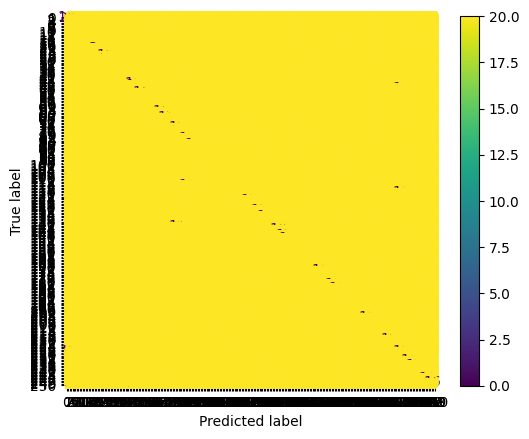

In [8]:
class ml_models(Enum):
    # LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    # KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    # KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    # KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    # KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    # NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]

model_accuracies = []
for model in ml_models:    
    model_name = "{}_from_{}_minus{}".format(model.value[1], chosen_net, layers_to_remove)
    score = model_building(model.value[0], model.value[1], X_train_ale_n, X_test_ale_n, y_train, y_test)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
np.save("./Transfer_Learning/model_metrics/Accuracies_{}_minus{}.npy".format(chosen_net, layers_to_remove), model_accuracies)

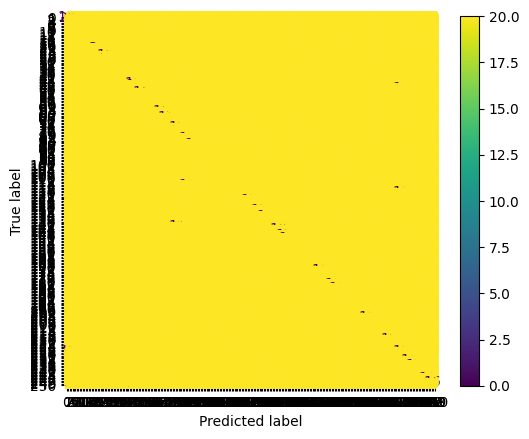

In [9]:
model = ml_models.RANDOM_FOREST.value[0]
y_pred = model.predict(X_test_ale_n)
acc=accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model.classes_)
disp.plot()
plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
cm = np.array(cm)
np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
with open('./Transfer_Learning/models/{}.pkl'.format(model_name),'wb') as f:
    pickle.dump(model,f)